In [135]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [136]:
# Load the dataset from 2013-01-01  to 2017-12-31
df = pd.read_csv('daily_sales.csv')

In [137]:
# check for null values in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [138]:
# drop store and item columns
df = df.drop(['store', 'item'], axis=1)

In [139]:
# change date dtype to datetime
df['date'] = pd.to_datetime(df['date'])

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


In [141]:
# convert date to a month period and then sum the number of items in each month
df['date'] = df['date'].dt.to_period('M')

In [142]:
monthly_df = df.groupby('date').sum().reset_index()

In [143]:
# convert date from datetime to timestamp dtype
monthly_df['date'] = monthly_df['date'].dt.to_timestamp()

In [144]:
monthly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    60 non-null     datetime64[ns]
 1   sales   60 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB


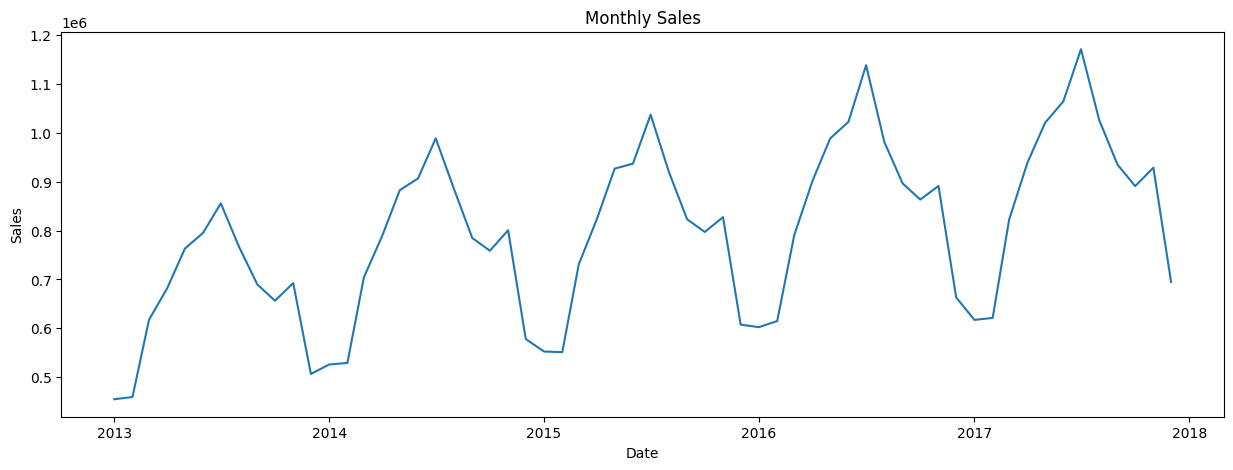

In [145]:
# Visualize
plt.figure(figsize=(15, 5))
plt.plot(monthly_df['date'], monthly_df['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Sales')
plt.show()

In [146]:
# make data stationary to improve forecast - create difference in monthly sales
monthly_df['sales_diff'] = monthly_df['sales'].diff()
monthly_df = monthly_df.dropna()
monthly_df.head()

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0


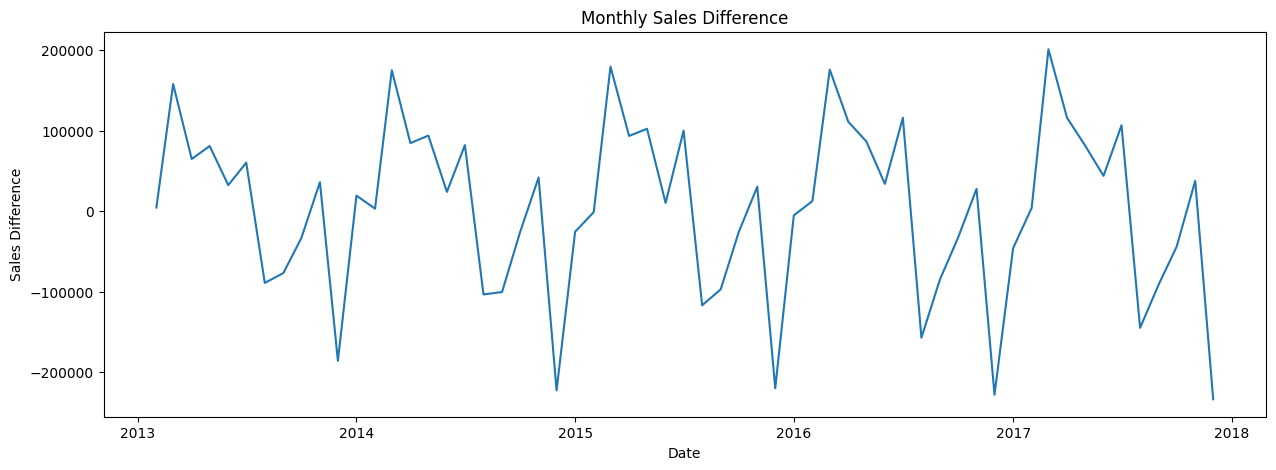

In [147]:
# Visualize
plt.figure(figsize=(15, 5))
plt.plot(monthly_df['date'], monthly_df['sales_diff'])
plt.xlabel('Date')
plt.ylabel('Sales Difference')
plt.title('Monthly Sales Difference')
plt.show()

In [148]:
# Drop off sales and date columns
supervised_data = monthly_df.drop(['sales', 'date'], axis=1)


In [149]:
supervised_data.head()

,sales_diff
1,4513.0
2,157965.0
3,64892.0
4,80968.0
5,32355.0


In [150]:
# Prep input output aka supervised data
for i in range(1,13):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head()

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0


In [151]:
# Split data into train and test
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]

print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (35, 13)
Test Data Shape:  (12, 13)


In [152]:
# Scale
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [157]:
x_train, y_train = train_data[:, 1:], train_data[:, 0:1]
x_test, y_test = test_data[:, 1:], test_data[:, 0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("X_train Shape", x_train.shape)
print("y_train Shape", y_train.shape)
print("X_test Shape", x_test.shape)
print("y_test Shape", y_test.shape)

X_train Shape (35, 12)
y_train Shape (35,)
X_test Shape (12, 12)
y_test Shape (12,)


In [160]:
# Forecast period
monthly_df['date'][-12:]

48   2017-01-01
49   2017-02-01
50   2017-03-01
51   2017-04-01
52   2017-05-01
53   2017-06-01
54   2017-07-01
55   2017-08-01
56   2017-09-01
57   2017-10-01
58   2017-11-01
59   2017-12-01
Name: date, dtype: datetime64[ns]

In [158]:
# Merge prediction data
sales_dates = monthly_df['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [161]:
actual_sales = monthly_df['sales'][-13:].to_list()
print(actual_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


In [162]:
# Create linear regression model
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_predict = lr_model.predict(x_test)

In [165]:
# Reinvert scaled data
lr_predict = lr_predict.reshape(-1, 1)

# Test set matrix of x_test and predicted output
lr_predict_test_set = np.concatenate([lr_predict, x_test], axis=1)
lr_predict_test_set = scaler.inverse_transform(lr_predict_test_set)

In [166]:
# calculate predicted sale value
result_list = []
for i in range(0, len(lr_predict_test_set)):
    result_list.append(lr_predict_test_set[i][0] + actual_sales[i])

lr_prediction_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_prediction_series, left_index=True, right_index=True)

In [167]:
# print forecast
print(predict_df)

         date  Linear Prediction
0  2017-01-01       6.479148e+05
1  2017-02-01       6.283374e+05
2  2017-03-01       8.195190e+05
3  2017-04-01       9.436391e+05
4  2017-05-01       1.033653e+06
5  2017-06-01       1.065286e+06
6  2017-07-01       1.201561e+06
7  2017-08-01       1.002123e+06
8  2017-09-01       9.415142e+05
9  2017-10-01       9.080646e+05
10 2017-11-01       9.167461e+05
11 2017-12-01       6.947978e+05


In [171]:
# Evaluate
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_df['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_df['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_df['sales'][-12:])

print(f"Linear Regression MSE: {lr_mse}")
print(f"Linear Regression MAE: {lr_mae}")
print(f"Linear Regression R2: {lr_r2}")

Linear Regression MSE: 16221.272385416887
Linear Regression MAE: 12433.184266490765
Linear Regression R2: 0.9906152516380968


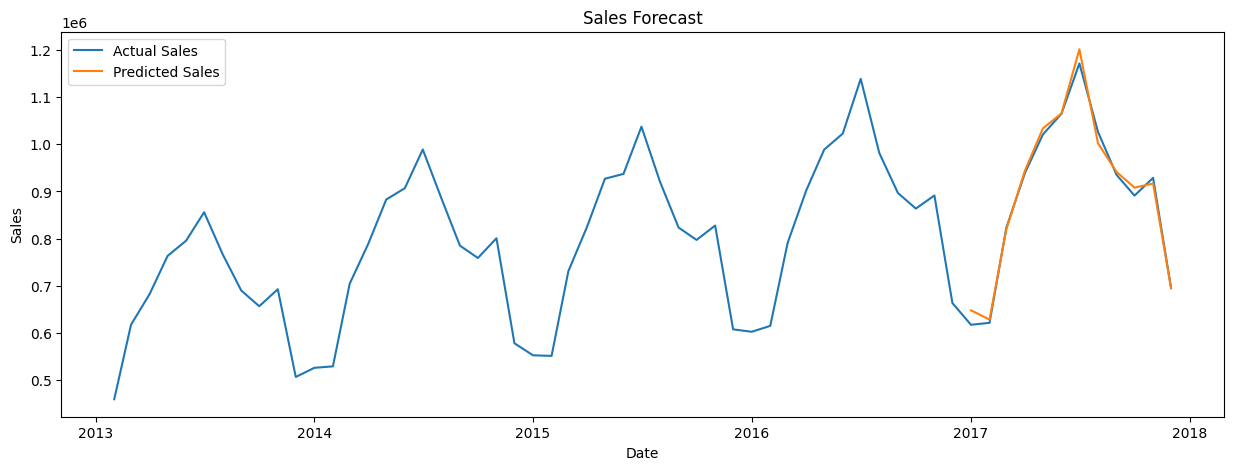

In [175]:
# Visualize
plt.figure(figsize=(15,5))
plt.plot(monthly_df['date'], monthly_df['sales'], label='Actual Sales')
plt.plot(predict_df['date'], predict_df['Linear Prediction'], label='Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Forecast')
plt.legend()
plt.show()